Episode: 100 - reward: -100.0
Episode: 200 - reward: -100.0
Episode: 300 - reward: -100.0
Episode: 400 - reward: -100.0
Episode: 500 - reward: -100.0
Episode: 600 - reward: -100.0
Episode: 700 - reward: -100.0
Episode: 800 - reward: -100.0
Episode: 900 - reward: -100.0
Episode: 1000 - reward: -100.0


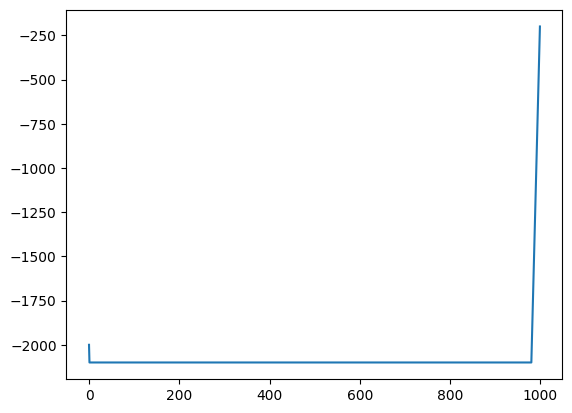

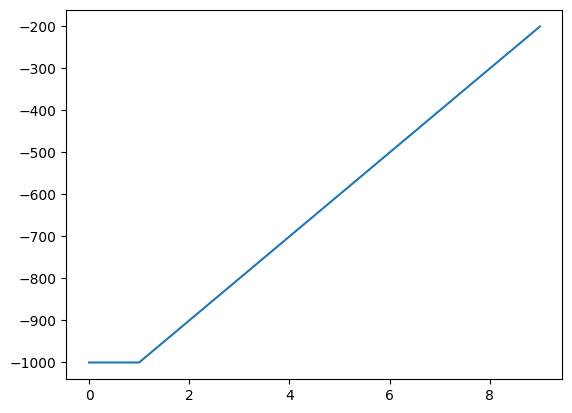

In [3]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import pickle

def discretize_state(state, bins):
    discrete_state = tuple(
        np.digitize(state[i], bins[i]) - 1 for i in range(len(state))
    )
    return discrete_state

def create_bins(num_bins, state_space):
    bins = []
    for i in range(len(state_space.low)):
        bins.append(np.linspace(state_space.low[i], state_space.high[i], num_bins + 1)[1:-1])
    return bins

def train(episodes, is_training=True, render=False):
    env = gym.make("LunarLander-v2", render_mode="human" if render else None)

    num_bins = 10
    if is_training:
        q_table = np.zeros([num_bins] * len(env.observation_space.low) + [env.action_space.n])
    else:
        with open("lunar_lander_II.pkl", "rb") as f:
            q_table = pickle.load(f)
    
    bins = create_bins(num_bins, env.observation_space)
    q_table = np.zeros([num_bins] * len(env.observation_space.low) + [env.action_space.n])
    counts = np.zeros([num_bins] * len(env.observation_space.low) + [env.action_space.n])
    
    learning_rate = 0.9
    discount_factor = 0.95
    epsilon = 1  # Exploration rate
    epsilon_decay_rate = 0.0001  # Exploration decay rate
    rng = np.random.default_rng()  # Random number generator
    
    rewards_per_episode = np.zeros(episodes)
    
    # Training loop
    for i in range(episodes):
            
        state = env.reset()[0]
        discrete_state = discretize_state(state, bins)
        
        terminated = False
        truncated = False
        
        while (not terminated and not truncated):
            if rng.random() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[discrete_state])
                
            new_state, reward, terminated, truncated, _ = env.step(action)
            new_discrete_state = discretize_state(new_state, bins)
            
            counts[discrete_state + (action,)] += 1
            alpha = 1 / counts[discrete_state + (action,)]
            if is_training:
                q_table[discrete_state + (action,)] += alpha * (
                    reward + discount_factor * np.max(q_table[new_discrete_state]) - q_table[discrete_state + (action,)]
                )
            
            state = new_state
            discrete_state = new_discrete_state
            
        epsilon = max(epsilon - epsilon_decay_rate, 0)
    
        rewards_per_episode[i] = reward
            
        if (i+1) % 100 == 0:
            print(f"Episode: {i+1} - reward: {rewards_per_episode[i]}") 
        
    env.close()

    if is_training:
        with open("lunar_lander_II.pkl", "wb") as f:
            pickle.dump(q_table, f)
        
    sum_rewards = np.zeros(episodes)
    for t in range(episodes):
         sum_rewards[t] = np.sum(rewards_per_episode[max(0, t-1):(t+20)])
        
    plt.plot(sum_rewards)
    plt.show()
        
if __name__ == "__main__":
    train(1000, is_training=True, render=False)
    train(10, is_training=False, render=True)